In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [18]:
train = pd.read_csv('./data/trainingWithItems.csv')

In [19]:
train.head()

,Unnamed: 0,YEAR FORECAST MADE,QUARTER,YEAR BEING FORECAST,INDICATOR,FORECASTER ID,INDUSTRY,Year.ID.ForecastYear.Quarter,Indicator.Year.ID.ForecastYear.Quarter,BIN 1,...,ACTUAL_CONF,HIT,pred_average,pred_var,chicken,coffee,eggs,electricity,rice,unleadedGasoline
0,0,1968,4,1968,NominalGNP,1,NaN,1968-1-1968-4,NominalGNP-1968-1-1968-4,0.0,...,0.00,0.0,6.00,0.4500,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1968,4,1968,NominalGNP,2,NaN,1968-2-1968-4,NominalGNP-1968-2-1968-4,0.0,...,0.00,0.0,6.10,1.0400,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1968,4,1968,NominalGNP,3,NaN,1968-3-1968-4,NominalGNP-1968-3-1968-4,0.0,...,0.00,0.0,6.80,0.4100,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1968,4,1968,NominalGNP,4,NaN,1968-4-1968-4,NominalGNP-1968-4-1968-4,0.0,...,0.00,0.0,6.15,1.3275,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1968,4,1968,NominalGNP,5,NaN,1968-5-1968-4,NominalGNP-1968-5-1968-4,3.0,...,0.04,0.0,4.65,7.2275,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
train.columns

Index(['Unnamed: 0', 'YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST',
       'INDICATOR', 'FORECASTER ID', 'INDUSTRY',
       'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST', 'actual',
       'ACTUAL_BIN', 'MAX', 'NUM_OF_MAX

In [21]:
train['INDICATOR'].value_counts()

RealGDP         13350
Unemployment     7968
Core CPI         4864
Core PCE         4864
NominalGNP       2686
RealGNP          2330
Name: INDICATOR, dtype: int64

In [22]:
unemp = train[train['INDICATOR'] == "Unemployment"]
rgdp = train[train['INDICATOR'] == "RealGDP"]
cpce = train[train['INDICATOR'] == "Core PCE"]
ccpi = train[train['INDICATOR'] == "Core CPI"]
ngnp = train[train['INDICATOR'] == "NominalGNP"]
rgnp = train[train['INDICATOR'] == "RealGNP"]

In [23]:
np.random.seed(0)
def model_setup(df):
    
    rand = df.sample(frac = 1)
    #80/20 split
    nrow = len(rand)
    train_prop = int(np.round(nrow*0.8))
    train = rand[:train_prop]
    val = rand[train_prop:]
    
    train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual",
                  "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]]
    val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual",
                  "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]]
    
    return train.dropna(), val.dropna()

In [24]:
def run_model(df, variable_name, plot=True):
    np.random.seed(0)

    train, val = model_setup(df)
    X_train, Y_train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                  "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], train[["actual"]]
    val_X, val_Y = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                  "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], val["actual"].tolist()

    fitted = MLPRegressor(hidden_layer_sizes=500, 
                          activation='relu',
                          solver='lbfgs', alpha=0.0001, batch_size='auto',
                          learning_rate='constant', learning_rate_init=0.0001, 
                          power_t=0.5, 
                          max_iter=5000
                          , shuffle=True, random_state=None, 
                          tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                          nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                          epsilon=1e-08, n_iter_no_change=10, max_fun=15000
                         ).fit(X_train, Y_train)
    
    preds = fitted.predict(val_X)
    
    preds = preds.flatten()
    

    pred = fitted.predict(val_X)
    pred = pred.flatten()
    
    diffs = np.subtract(val_Y, preds)

    r21 = np.corrcoef(val_Y, preds)[0][1]
    r22 = np.corrcoef(val_Y, np.array(val_X['pred_average'].tolist()))[0][1]
    
    mse1 = mean_squared_error(val_Y, preds)
    mse2 = mean_squared_error(val_Y, np.array(val_X['pred_average'].tolist()))
    
    if plot == True:
        print("Differences in actual vs. model prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(diffs)))
        print("Median: " + str(np.median(diffs)))
        print("Max: " + str(max(diffs)))
        print("Min: " + str(min(diffs)))
        print("Correlation Coef: " + str(r21))
        print("MSE: " + str(mse1))

        plt.hist(diffs)
        plt.title("Actual minus Model Prediction (" + variable_name + ")")
        plt.show()

        actual_diffs = np.subtract(val_Y, np.array(val_X['pred_average'].tolist()))
        print("Differences in actual vs. forecaster average prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(actual_diffs)))
        print("Median: " + str(np.median(actual_diffs)))
        print("Max: " + str(max(actual_diffs)))
        print("Min: " + str(min(actual_diffs)))
        print("Correlation Coef: " + str(r22))
        print("MSE: " + str(mse2))

        plt.hist(actual_diffs)
        plt.title("Actual Rate minus Forecaster Average Prediction (" + variable_name + ")")
        plt.show()
        
    else:
        return mse1, mse2, r21, r22

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Differences in actual vs. model prediction (Unemployment)
Mean: 0.044737852350451156
Median: 0.17825104299576244
Max: 5.7952168947758995
Min: -8.373827111006161
Correlation Coef: 0.7757645622822273
MSE: 3.0841627590239233


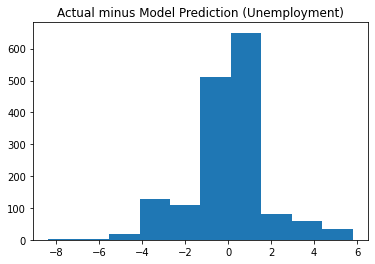

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -0.9148486938035417
Median: -0.6062500000000002
Max: 9.058333
Min: -8.475
Correlation Coef: 0.6334274949969275
MSE: 5.4746766338827


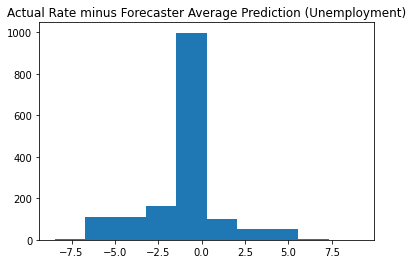

In [25]:
run_model(unemp, "Unemployment")

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Differences in actual vs. model prediction (Real GDP)
Mean: 0.010982502762330022
Median: 0.11179548769405612
Max: 3.790648920763884
Min: -6.666471937082525
Correlation Coef: 0.8623593560031039
MSE: 0.8582315771398117


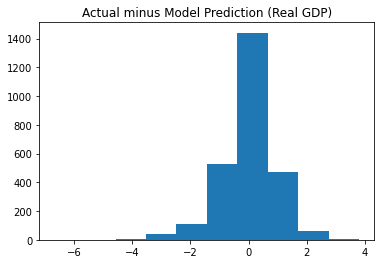

Differences in actual vs. forecaster average prediction (Real GDP)
Mean: -0.4350808469014078
Median: -0.22382000000000013
Max: 3.921817361570293
Min: -8.33626
Correlation Coef: 0.5074985032649435
MSE: 2.67996089663907


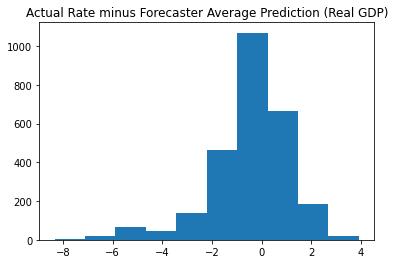

In [26]:
run_model(rgdp, "Real GDP")

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Differences in actual vs. model prediction (Core CPE)
Mean: -0.036619405539487386
Median: 0.02108000259773979
Max: 6.472835247615197
Min: -7.640039391718242
Correlation Coef: 0.6571844512239989
MSE: 0.7944151953203267


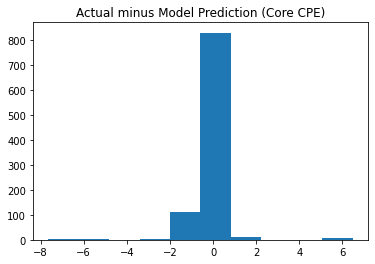

Differences in actual vs. forecaster average prediction (Core CPE)
Mean: -0.13042343653869268
Median: -0.24247432281050996
Max: 7.358333
Min: -3.025
Correlation Coef: -0.03825494620637904
MSE: 1.5887023418091215


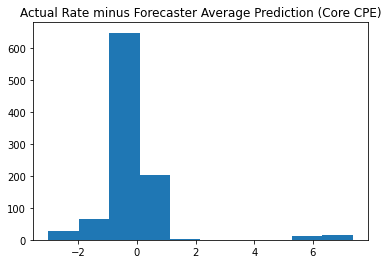

In [27]:
run_model(cpce, "Core CPE")

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Differences in actual vs. model prediction (Core CPI)
Mean: -0.026635736413157505
Median: -0.005951483374429634
Max: 6.5065937926662425
Min: -4.406077988078479
Correlation Coef: 0.6183744659413816
MSE: 0.8428110904800601


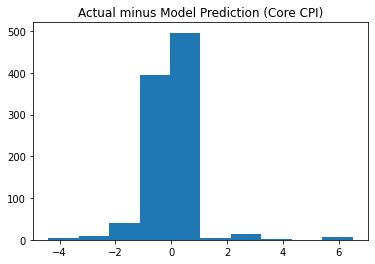

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: -0.08500913498683056
Median: -0.14789993895520004
Max: 7.059333
Min: -4.25580034612723
Correlation Coef: 0.07473335298292898
MSE: 1.5989834454961678


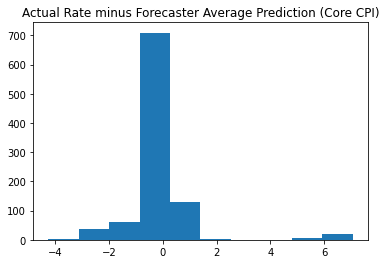

In [28]:
run_model(ccpi, "Core CPI")

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Differences in actual vs. model prediction (Nominal GNP)
Mean: -0.11160400972507556
Median: -0.14111216082613431
Max: 1.2891702994735486
Min: -1.0407779523639906
Correlation Coef: 0.9561187262962371
MSE: 0.244942367326203


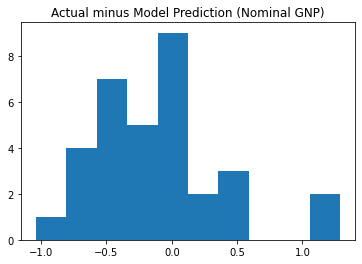

Differences in actual vs. forecaster average prediction (Nominal GNP)
Mean: 0.21877606060606117
Median: 0.23313000000000095
Max: 3.1331300000000013
Min: -1.44801
Correlation Coef: 0.9180921645943418
MSE: 0.7521179713969702


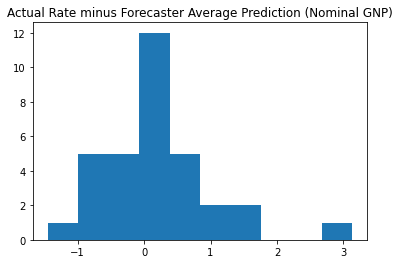

In [29]:
run_model(ngnp, "Nominal GNP")

/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Differences in actual vs. model prediction (Real GNP)
Mean: 0.11335829772830636
Median: 0.18977299575687923
Max: 5.359848033564293
Min: -4.3970855133027555
Correlation Coef: 0.8482060263775703
MSE: 1.5731459680914965


/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


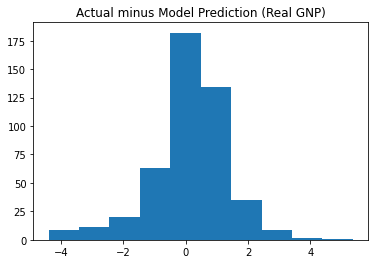

Differences in actual vs. forecaster average prediction (Real GNP)
Mean: 0.880710956351935
Median: 0.9083349999999999
Max: 7.90641
Min: -4.73796
Correlation Coef: 0.7455494390877575
MSE: 3.246295661443907


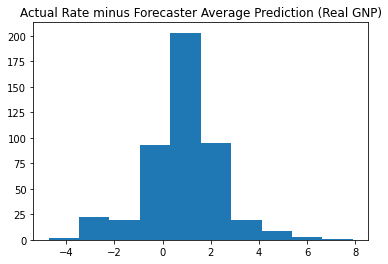

In [30]:
run_model(rgnp, "Real GNP")